Import the required libraries

In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from PIL import Image
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
import tensorflow as tf

Import the dataset

In [2]:
mnist = tf.keras.datasets.mnist
data=mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Extract the training and test data from the dataset

In [3]:
train_x=data[0][0]
train_y=data[0][1].reshape(-1,1)
test_x=data[1][0]
test_y=data[1][1].reshape(-1,1)


Clean the dataset

In [4]:
# Process the data

def clean_data(x,y):


  # Flatten the data
  samples=[]
  for sample in x[:]:
    samples.append(sample.flatten())

  x=np.array(samples)

  # Encode the labels
  enc=OneHotEncoder()

  enc.fit(y)

  onehotlabels = enc.transform(y).toarray()
  y=onehotlabels

  # Shuffle the data
  x,y=shuffle(x,y)

  # Scale the data
  scaler=MinMaxScaler(feature_range=(-1,1))

  x=scaler.fit_transform(x)

  print(x.shape,y.shape)



  return x,y



train_x,train_y=clean_data(train_x,train_y)
test_x,test_y=clean_data(test_x,test_y)

(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


Define the latent dimensions and the dimension of auxilary input, i.e., the number of classes.

In [5]:
z_dim=100
num_classes=10

Build the generator- a FC Network with architecture 110 x 200 x 400 x 784. The model accepts a noise vector sample from normal distribution and the one hot encoded labels as the the condition vector. 

In [6]:
noise=Input(shape=(z_dim,))
aux_inp=Input(shape=(num_classes,))

def build_generator():
  model=Sequential()
  
  model.add(Dense(units=200,kernel_initializer='HeNormal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  
  model.add(Dense(units=400,kernel_initializer='HeNormal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(units=784,activation='tanh',kernel_initializer='HeNormal'))

  model_inp=Concatenate(axis=1)([noise,aux_inp])

  gen_img=model(model_inp)

  return Model([noise,aux_inp],gen_img,name='generator')

generator = build_generator()
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 784)          419384      concatenate[0][0]        

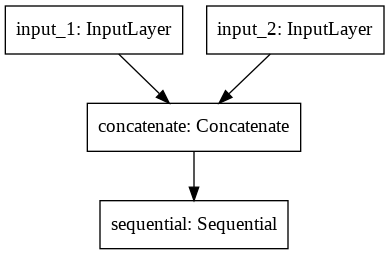

In [7]:
tf.keras.utils.plot_model(generator)

Build the discriminator- a FC Network with architecture 794 x 400 x 200 x 100 x 1. The model accepts a flattened image vector and the one hot encoded labels. The discriminator outputs a label between 0,1 which indicates whether the image is fake or real.

In [8]:
def build_discriminator():
  model=Sequential()
  
  model.add(Dense(units=400,kernel_initializer='HeNormal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.2))

  model.add(Dense(units=200,kernel_initializer='HeNormal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.2))

  model.add(Dense(units=100,kernel_initializer='HeNormal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.1))

  model.add(Dense(units=1,activation='sigmoid',kernel_initializer='GlorotNormal'))

  dis_inp_img=Input(shape=(784,))
  dis_inp_label=Input(shape=(num_classes,))

  model_inp=Concatenate(axis=1)([dis_inp_img,dis_inp_label])
  
  dis_pred=model(model_inp)

  return Model([dis_inp_img,dis_inp_label],dis_pred,name='Discriminator')

discriminator = build_discriminator()
discriminator.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 794)          0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1)            418401      concatenate_1[0][0]  

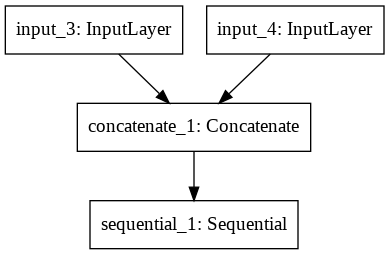

In [9]:
tf.keras.utils.plot_model(discriminator)

Let's compite the discriminator network-

In [10]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = Adam(0.0002, 0.5), metrics = ['binary_accuracy'])

Let's build the CGAN model. The model uses the generator to generate fake images and the discriminator is validate the generated images.

In [11]:
discriminator.trainable = False
img = generator([noise,aux_inp])
prediction = discriminator([img, aux_inp])
conditionalGAN_model = Model([noise, aux_inp], prediction)
conditionalGAN_model.compile(loss= 'binary_crossentropy', optimizer = Adam(0.0002,0.5))

In [12]:
conditionalGAN_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
generator (Functional)          (None, 784)          419384      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
Discriminator (Functional)      (None, 1)            418401      generator[0][0]       

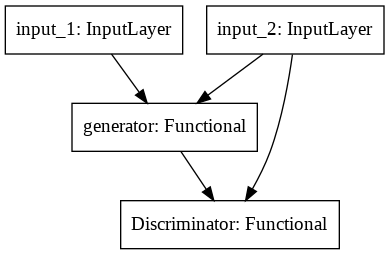

In [13]:
tf.keras.utils.plot_model(conditionalGAN_model)

Lets train the network-

In [14]:
import os

if 'images' not in os.listdir():
    os.mkdir('images')

def save_image(epoch):
  
  r, c = 2,5
  z = np.random.normal(0,1,(r*c, z_dim))
  labels = np.eye(num_classes)
  gen_image = generator.predict([z,labels])
  gen_image = 0.5 * gen_image + 0.5
    
  fig, axes = plt.subplots(r,c, figsize = (10,10))
  count = 0
  for i in range(r):
    for j in range(c):
      axes[i,j].imshow(gen_image[count,:].reshape((28,28)),cmap = 'gray')
      axes[i,j].axis('off')
      axes[i,j].set_title("Digit: %d" % np.argmax(labels[count,:]))
      count+=1
  plt.savefig(f'images/cgan_{epoch}.jpg')
  plt.close()




def train(epochs, batch_size, save_interval):
  real = np.ones(shape= (batch_size, 1))
  fake = np.zeros(shape = (batch_size,1))
  
  real_accs=[]
  fake_accs=[]

  gen_losses=[]
  d_losses=[]
  for epoch in range(epochs):
    

    #disc_batch_accuracy_real=[]
    #disc_batch_accuracy_fake=[]
    #gen_batch_loss=[]
    
    for i in range(0,len(train_x),batch_size):
      
      discriminator.trainable = True
      
      img, labels = train_x[i:i+batch_size,:], train_y[i:i+batch_size,:]
      d_batch_loss_real,d_batch_acc_real = discriminator.train_on_batch([img, labels], real[:len(labels),:])

      z = np.random.normal(0,1,size = (batch_size, z_dim))
      fake_labels = np.eye(num_classes)[np.random.choice(num_classes, batch_size,replace=True)]
      gen_img = generator.predict([z,fake_labels])
      d_batch_loss_fake,d_batch_acc_fake = discriminator.train_on_batch([gen_img, fake_labels], fake[:len(fake_labels),:])

      d_loss=(d_batch_loss_real+d_batch_loss_fake)/2



      discriminator.trainable = False
      z = np.random.normal(0,1,size = (batch_size, z_dim))
      labels = np.eye(num_classes)[np.random.choice(num_classes, batch_size,replace=True)]
      g_loss = conditionalGAN_model.train_on_batch([z,labels], real)
    
    
    epoch_real_accuracy=d_batch_acc_real
    epoch_fake_accuracy=d_batch_acc_fake
    epoch_gen_loss=g_loss
    epoch_d_losses=d_loss
    print(f"Epoch: {epoch} Disc. Loss: {epoch_d_losses} Real Img Accuracy: {epoch_real_accuracy} Fake Img Accuracy: {epoch_fake_accuracy} Gen Loss- {epoch_gen_loss}")

    real_accs.append(epoch_real_accuracy)
    fake_accs.append(epoch_fake_accuracy)
    gen_losses.append(epoch_gen_loss)
    d_losses.append(epoch_d_losses)

    if epoch % save_interval == 0:
      save_image(epoch)
  
  return (real_accs,fake_accs,gen_losses,d_losses)



history=train(200, 64, 10)

Epoch: 0 Disc. Loss: 0.6863815188407898 Real Img Accuracy: 0.53125 Fake Img Accuracy: 0.65625 Gen Loss- 1.2257654666900635
Epoch: 1 Disc. Loss: 0.6275473237037659 Real Img Accuracy: 0.53125 Fake Img Accuracy: 0.734375 Gen Loss- 1.3344742059707642
Epoch: 2 Disc. Loss: 0.41264232993125916 Real Img Accuracy: 0.75 Fake Img Accuracy: 0.84375 Gen Loss- 1.691371202468872
Epoch: 3 Disc. Loss: 0.3906012177467346 Real Img Accuracy: 0.78125 Fake Img Accuracy: 0.90625 Gen Loss- 1.8140895366668701
Epoch: 4 Disc. Loss: 0.4175615906715393 Real Img Accuracy: 0.8125 Fake Img Accuracy: 0.78125 Gen Loss- 1.5750070810317993
Epoch: 5 Disc. Loss: 0.46996021270751953 Real Img Accuracy: 0.71875 Fake Img Accuracy: 0.796875 Gen Loss- 1.329421043395996
Epoch: 6 Disc. Loss: 0.5139704048633575 Real Img Accuracy: 0.71875 Fake Img Accuracy: 0.796875 Gen Loss- 1.2875171899795532
Epoch: 7 Disc. Loss: 0.4629201740026474 Real Img Accuracy: 0.875 Fake Img Accuracy: 0.78125 Gen Loss- 1.1917533874511719
Epoch: 8 Disc. Loss

In [15]:
#import shutil
#shutil.rmtree('images')

Let's generate the digits using our trained generator- 

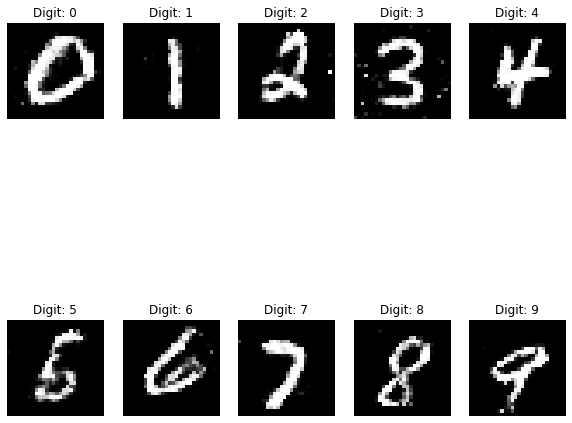

In [16]:
r, c = 2,5
z = np.random.normal(0,1,(r*c, z_dim))
labels = np.eye(num_classes)
gen_image = generator.predict([z,labels])
gen_image = 0.5 * gen_image + 0.5
    
fig, axes = plt.subplots(r,c, figsize = (10,10))
count = 0
for i in range(r):
  for j in range(c):
    axes[i,j].imshow(gen_image[count,:].reshape((28,28)),cmap = 'gray')
    axes[i,j].axis('off')
    axes[i,j].set_title("Digit: %d" % np.argmax(labels[count,:]))
    count+=1
  


Let plot the fake image classification accuracy and the real image classification accuracy of the discriminator-  

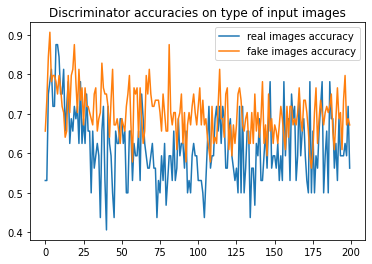

In [17]:
plt.plot(history[0],label='real images accuracy');
plt.plot(history[1],label='fake images accuracy');
plt.title("Discriminator accuracies on type of input images")
plt.legend();

Lets save the models- 

In [19]:
conditionalGAN_model.save('cgan.h5')

In [20]:
discriminator.save('discriminator.h5')

In [21]:
generator.save('generator.h5')

Now lets generate 10 images for each digit-

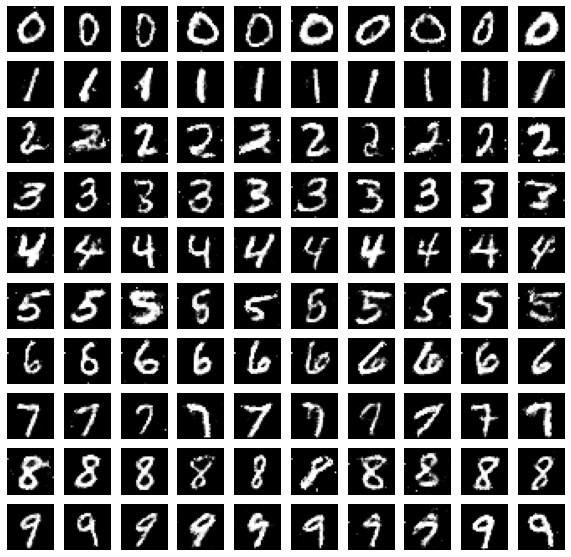

In [26]:
r, c = 10,10
z = np.random.normal(0,1,(r*c, z_dim))


labels=[]
for vector in np.eye(num_classes):
  #print(vector)
  for _ in range(10):
    labels.append(vector.tolist())

labels=np.array(labels)
#print(labels.shape)

gen_image = generator.predict([z,labels])

gen_image = 0.5 * gen_image + 0.5
    
fig, axes = plt.subplots(r,c, figsize = (10,10))
count = 0
for i in range(r):
  for j in range(c):
    axes[i,j].imshow(gen_image[count,:].reshape((28,28)),cmap = 'gray')
    axes[i,j].axis('off')
    #axes[i,j].set_title("Digit: %d" % np.argmax(labels[count,:]))
    count+=1

The images are sharp. Looks like our CGAN model did a pretty good job. I trained the model only for 200 epochs. I am guessing that I would get better results if I trained the model more. 